## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib qt

## Step 1: Compute the camera calibration using chessboard images

In [2]:
# camera calibration

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

# Create a dictionary with camera calibration information        
camera_cal_info = {'ret': ret, 'mtx': mtx, 'dist': dist, 'rvecs': rvecs, 'tvecs': tvecs}
    


## Step 2: Do the distortion correction. 

In [3]:
def cal_undistort(img):
    # Use cv2.calibrateCamera() and cv2.undistort()
    
    mtx = camera_cal_info['mtx']
    dist = camera_cal_info['dist']
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return mtx, dist, undist

## Step3: Use color transforms, gradients, etc., to create a thresholded binary image, where the lane lines are clearly visible.

### 3a: After trial and error, I found the 3 thresholds are good to gerenrate a binary image - HLS' S thresholding, HSV's V thresholding and absolute sobel x thresholding for the <project_video.mp4>.  But for the <challenge_video.mp4>, it's totally a different story. I have to retune the masks and add region_of_interest in order to work for both videos

In [4]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [5]:
# Define a color thresholding based on HLS' S value
def color_hls_thresh(img, s_thresh=(0, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    color_binary = np.zeros_like(s_channel)
    color_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    return color_binary

In [6]:
# Define a color thresholding based on HSV's V value
def color_hsv_thresh(img, v_thresh=(0, 255)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hls[:,:,2]
    
    # Threshold color channel
    color_binary = np.zeros_like(v_channel)
    color_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    return color_binary

In [7]:
# Define a function that applies Sobel x or y, then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel_derivative = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel_derivative = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel_derivative)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
      
    return binary_output

## 3b: Apply the masks to create a thresholded binary image, where the lane lines are clearly visible.

In [8]:
# Apply mask to call the abs_sobel_thresh, color_hls_thresh and color_hvs_thresh

def mask_apply(img):
    
    imshape = img.shape
    vertices = np.array([[(0,imshape[0]),(600, 420), (680, 420), (imshape[1],imshape[0])]], dtype=np.int32)

    img_roi = region_of_interest(img, vertices)
    hls_temp = color_hls_thresh(img_roi, s_thresh=(125, 255))
    hls_temp_sum = np.sum(hls_temp)
    hsv_temp = color_hsv_thresh(img_roi, v_thresh=(180, 255))
    hsv_temp_sum = np.sum(hsv_temp)
    
    grad_binary = abs_sobel_thresh(img, orient='x', thresh_min=70, thresh_max=100)
    combined_binary = np.zeros_like(grad_binary)
    magic_number = 7000
    if (hls_temp_sum > magic_number) and (hsv_temp_sum > magic_number): # 7000 is a magic number here :)
        # I've found this mask binary combination work good for <project_video.mp4> (high HLS' S value images) 
        # But it didn't work good for <challenge_video.mp4>
        # Then I came up the code in the else condition. 
        # it works pretty good for the <challenge_video.mp4> (low HLS' S value images)
        # At the end, I constructed a magic threshold from the test images.
        # It would switch between 2 mask binary combinations
        # By combination, it works pretty good most of the time for the video.
        # However, it sacrifices a little bit on the test images.
        # There is still room to improve if I have more time for more metrics
        
        color_hls_binary = color_hls_thresh(img, s_thresh=(125, 255))
        color_hsv_binary = color_hsv_thresh(img, v_thresh=(200, 255))
        combined_binary[(grad_binary == 1) | (color_hls_binary == 1) & (color_hsv_binary == 1)] = 1 
    else:
        color_hsv_binary = color_hsv_thresh(img, v_thresh=(180, 255))
        combined_binary[(grad_binary == 1) | (color_hsv_binary == 1)] = 1 

    combined_binary = region_of_interest(combined_binary, vertices)
    
    return combined_binary 

In [9]:
## from the test_images to find a threshold (magic number) to switch 2 different masks for 2 testing videos
# # image = cv2.imread('./test_images/challenge_image_1.jpg')
# image = cv2.imread('./test_images/test6.jpg')
# standard_im = cv2.resize(image, (1280, 720))
# rgb_image = cv2.cvtColor(standard_im, cv2.COLOR_BGR2RGB)
# mtx, dist, undist_rgb_image = cal_undistort(rgb_image)

# imshape = undist_rgb_image.shape
# vertices = np.array([[(0,imshape[0]),(600, 420), (680, 420), (imshape[1],imshape[0])]], dtype=np.int32)
# img_roi = region_of_interest(undist_rgb_image, vertices)
    
# mask_binary = combined_binary_result = mask_apply(undist_rgb_image)

# hls_temp = color_hls_thresh(img_roi, s_thresh=(125, 255))
# hls_temp_sum = np.sum(hls_temp)
# hsv_temp = color_hsv_thresh(img_roi, v_thresh=(180, 255))
# hsv_temp_sum = np.sum(hsv_temp)
# print('hsv_temp_sum',hsv_temp_sum)
# print('hls_temp_sum',hls_temp_sum)

# # Plot the result
# f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
# f.tight_layout()

# ax1.imshow(rgb_image)
# ax1.set_title('Original Image', fontsize=20)

# ax2.imshow(hls_temp, cmap='gray')
# ax2.set_title('HLS', fontsize=20)

# ax3.imshow(hsv_temp, cmap ='gray')
# ax3.set_title('HSV', fontsize=20)

# ax4.imshow(mask_binary, cmap ='gray')
# ax4.set_title('MASK', fontsize=20)

# plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)



## step 4: Apply a perspective transform to rectify binary image ("birds-eye view").


In [10]:
def perspective_transform(img):

    img_size = (img.shape[1], img.shape[0])
    
    # Define source points and destination 
    x_offset = 350 # define the line x offset in bird eye view
#     y_offset = 550 # define the line y offset in bird eye view
    y_offset = 450 # define the line y offset in bird eye view
    
    # four corner points order: top left, top right, bottom left, bottom right
    src = np.float32([[520, 500], [768.5, 500], [210,img.shape[0]],[1120,img.shape[0]]])
    dst = np.float32([[0 + x_offset, 0 + y_offset], [img.shape[1]-x_offset, 0 + y_offset], 
                      [0 + x_offset,img.shape[0]],[img.shape[1]-x_offset,img.shape[0]]])
  
    
    # Calculate the perspective transform matrix from the src and dst points
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)

    # Return the resulting image and matrix
    return warped, M, Minv

In [11]:
# Debug Test perspective_transform
# image = cv2.imread('./test_images/test1.jpg')
# # image = cv2.imread('./test_images/straight_lines2.jpg')
# rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# mtx, dist, undist = cal_undistort(rgb_image)
# top_down_img,M,Minv = perspective_transform(undist)

# # Plot the result
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
# f.tight_layout()
# ax1.imshow(rgb_image)
# ax1.set_title('Original', fontsize=18)

# ax2.imshow(top_down_img)
# ax2.set_title('Top Down Image', fontsize=18)
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## step 5: find lane pixels

In [12]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

### Polynomial fit

In [13]:
def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    if len(leftx) > 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    else:
        left_fit = [0, 0 ,0]
    
    if len(rightx) > 0:
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = [0, 0, 0]

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1,binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
        

    return left_fitx, right_fitx, ploty, out_img

## Step 6: Determine the curvature of the lane and vehicle position with respect to center

In [14]:
def measure_curvature_offset_real(ploty, leftx, rightx):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/600 # meters per pixel in x dimension, # 600 is from mean pixel valuve between left and right lane

    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2) 
       
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)


    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
   
    # Offset from center
    offset_px = 1280/2 - (leftx[-1] + rightx[-1])/2
    center_offset = offset_px*xm_per_pix
    
    return left_curverad, right_curverad, center_offset

In [15]:
# # test measure_curvature_pixels
# # Calculate the radius of curvature in pixels for both lane lines
# image = cv2.imread('./test_images/test4.jpg')
# # image = cv2.imread('./test_images/straight_lines2.jpg')

# rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# mtx, dist, undist_rgb_image = cal_undistort(rgb_image)
# combined_binary_result = mask_apply(undist_rgb_image)
# top_down_img, M, Minv = perspective_transform(combined_binary_result)

# left_fitx, right_fitx, ploty, out_img = fit_polynomial(top_down_img)

# left_curverad, right_curverad, center_offset = measure_curvature_offset_real(ploty, left_fitx, right_fitx)
# print(left_curverad, right_curverad, center_offset)

## Step 7: Warp the detected lane boundaries back onto the original image

In [16]:
def draw_detected_lane(image, binary_warped, left_fitx, right_fitx, ploty, Minv ):
    # Create an image to draw the lines on
   
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    color_warp = np.zeros_like(out_img)
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    return result

## Step 8: Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [17]:
image = cv2.imread('./test_images/test3.jpg')
# image = cv2.imread('./test_images/challenge_image_6.jpg')

# image = cv2.imread('./test_images/straight_lines2.jpg')

standard_im = cv2.resize(image, (1280, 720))
# OpenCV uses BGR as its default colour order for images, matplotlib uses RGB. 
# When we display an image loaded with OpenCv in matplotlib the channels will be back to front.
# Here I convert the BRG to RGB image
rgb_image = cv2.cvtColor(standard_im, cv2.COLOR_BGR2RGB)

# Apply a distortion correction to raw images.
mtx, dist, undist_rgb_image = cal_undistort(rgb_image)

# Use color transforms, gradients, etc., to create a thresholded binary image, where the lane lines are clearly visible.
combined_binary_result = mask_apply(undist_rgb_image)

# Top-down view image
top_down_img, M, Minv = perspective_transform(combined_binary_result)

# polyfit the found lanes
left_fitx, right_fitx, ploty, out_img = fit_polynomial(top_down_img)

image_line = draw_detected_lane(rgb_image, top_down_img, left_fitx, right_fitx, ploty, Minv)

left_curverad, right_curverad, center_offset = measure_curvature_offset_real(ploty, left_fitx, right_fitx)
radius = (left_curverad + right_curverad)/2

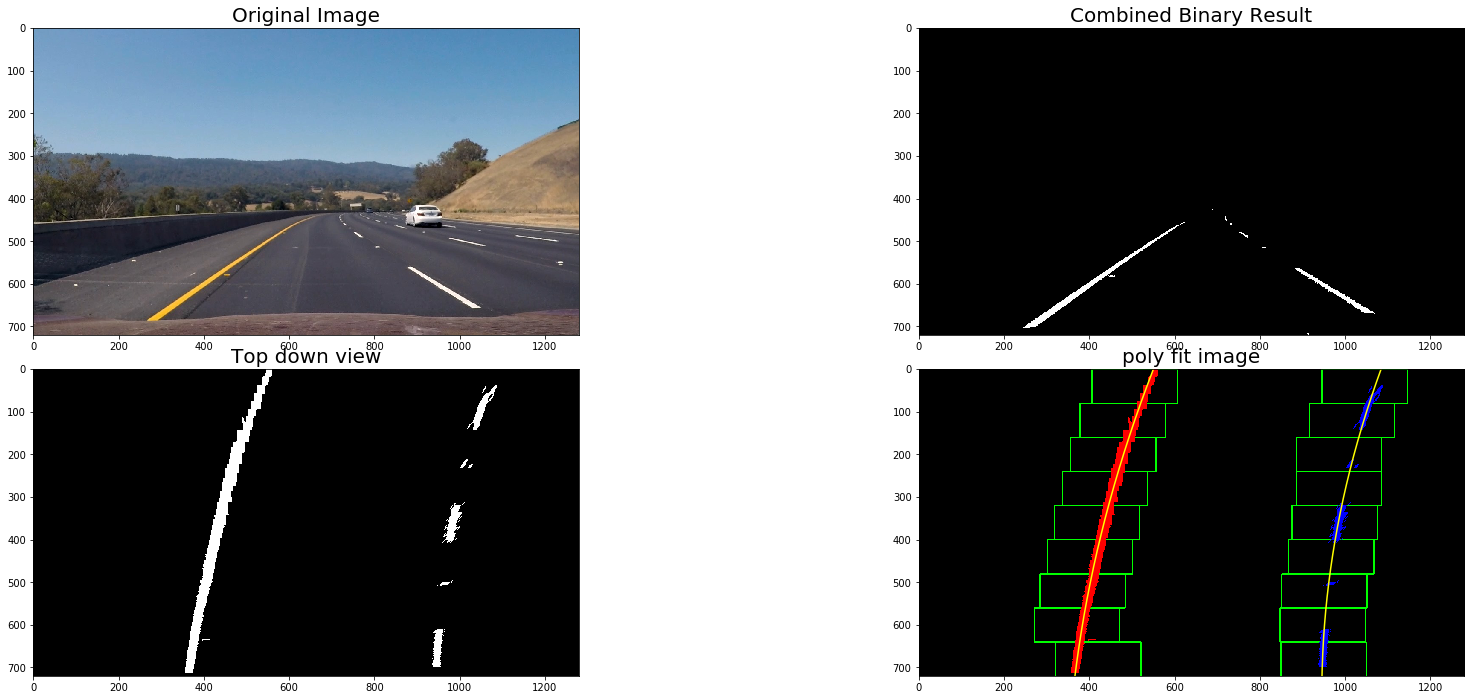

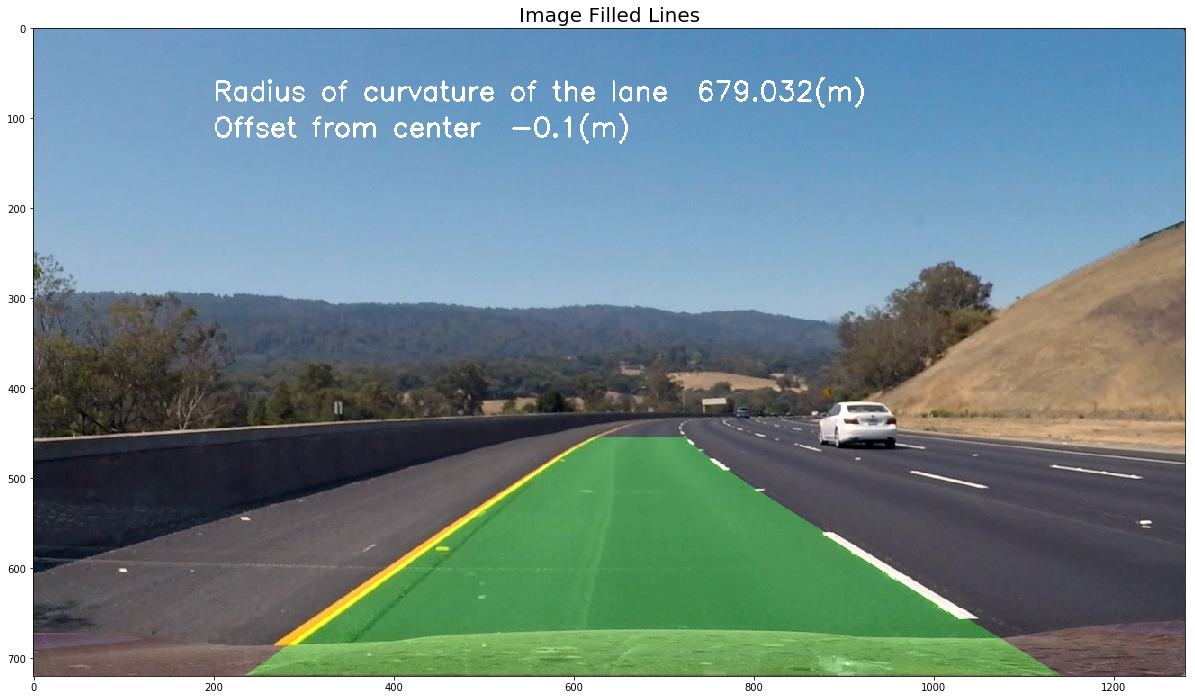

In [18]:
# Plot the result
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(rgb_image)
ax1.set_title('Original Image', fontsize=20)

ax2.imshow(combined_binary_result, cmap='gray')
ax2.set_title('Combined Binary Result', fontsize=20)

ax3.imshow(top_down_img, cmap ='gray')
ax3.set_title('Top down view', fontsize=20)

ax4.imshow(out_img)
ax4.set_title('poly fit image', fontsize=20)
ax4.plot(left_fitx, ploty, color='yellow')
ax4.plot(right_fitx, ploty, color='yellow')
plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)


f, ax1 = plt.subplots(1, 1, figsize=(24, 9))
f.tight_layout()
cv2.putText(image_line, 'Radius of curvature of the lane  {}(m)'.format(round(radius, 3)), (200,20*4),fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2) 
cv2.putText(image_line, 'Offset from center  {}(m)'.format(round(center_offset,3)), (200, 20*6),fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2) 
ax1.imshow(image_line)
ax1.set_title('Image Filled Lines', fontsize=20)
plt.subplots_adjust(left=0., right=1, top=1, bottom=0.)

## Test on Video

In [19]:
import collections

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, bool_isleft):
        # was the line detected in the last iteration?
        self.detected = False
        # a flag for left or right lane
        self.is_left = bool_isleft
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = [np.array([False])]  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # queue with past detections, up to 20
        self.past_fit = collections.deque(maxlen=20)
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # line to draw
        self.line_draw = []
        
    def find_lane_blind_search(self, binary_warped, out_img, nwindows = 9):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)


        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        
        if (self.is_left):
            x_base = np.argmax(histogram[:midpoint])
        else:
            x_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
#         nwindows = 9
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 50

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated later for each window in nwindows
        x_current = x_base

        # Create empty lists to receive lane pixel indices
        lane_inds = []
        

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_x_low = x_current - margin
            win_x_high = x_current + margin

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_x_low,win_y_low), (win_x_high,win_y_high),(0,255,0), 2) 

            # Identify the nonzero pixels in x and y within the window #
            good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                         (nonzerox >= win_x_low) &  (nonzerox < win_x_high)).nonzero()[0]

            # Append these indices to the lists
            lane_inds.append(good_inds)

            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_inds) > minpix:
                x_current = np.int(np.mean(nonzerox[good_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            lane_inds = np.concatenate(lane_inds)
 
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 

        if len(x) > 0:
            # Fit new polynomials
            self.current_fit = np.polyfit(y, x, 2)
            self.past_fit.append(self.current_fit)
            self.best_fit = np.array(self.past_fit).sum(axis=0)/len(self.past_fit)
#             self.best_fit = self.current_fit
            
           # Fit new polynomials
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
            fitx = self.best_fit[0]*ploty**2 + self.best_fit[1]*ploty + self.best_fit[2]
            
            
            ## Visualization ##
            if (self.is_left):
                out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [255, 0, 0]
            else:
                out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [0, 0, 255]
            
            self.detected = True

            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            line_window1 = np.array([np.transpose(np.vstack([fitx - margin, ploty]))])
            line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx + margin, ploty])))])
            self.line_draw = np.hstack((line_window1, line_window2))
            
        else:
            self.detected = False # If no lane pixels were detected then perform blind search
#             self.past_fit = []
            self.current_fit = []
            self.best_fit = []
            fitx = []
            x = []
            y = []
            ploty = []
            
        return fitx, x, y, ploty
    
    def find_lane_from_prior(self, binary_warped, out_img):

        # HYPERPARAMETER
        # Choose the width of the margin around the previous polynomial to search
        # The quiz grader expects 100 here, but feel free to tune on your own!
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        ### Set the area of search based on activated x-values ###
        ### within the +/- margin of our polynomial function ###
        lane_inds = ((nonzerox > (self.best_fit[0]*(nonzeroy**2) + self.best_fit[1]*nonzeroy + 
                        self.best_fit[2] - margin)) & (nonzerox < (self.best_fit[0]*(nonzeroy**2) + 
                        self.best_fit[1]*nonzeroy + self.best_fit[2] + margin)))
    

        # Again, extract left and right line pixel positions
        x = nonzerox[lane_inds]
        y = nonzeroy[lane_inds] 

        if len(x) > 0:
            # Fit new polynomials
            self.current_fit = np.polyfit(y, x, 2)
            self.past_fit.append(self.current_fit)
            self.best_fit = np.array(self.past_fit).sum(axis=0)/len(self.past_fit)
            
           # Fit new polynomials
            ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
            fitx = self.best_fit[0]*ploty**2 + self.best_fit[1]*ploty + self.best_fit[2]
            
            ## Visualization ##
            if (self.is_left):
                out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [255, 0, 0]
            else:
                out_img[nonzeroy[lane_inds], nonzerox[lane_inds]] = [0, 0, 255]

            # Generate a polygon to illustrate the search window area
            # And recast the x and y points into usable format for cv2.fillPoly()
            line_window1 = np.array([np.transpose(np.vstack([fitx - margin, ploty]))])
            line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx + margin, ploty])))])
            self.line_draw = np.hstack((line_window1, line_window2))
            
        else:
            self.detected = False # If no lane pixels were detected then perform blind search
#             self.past_fit = []
            self.current_fit = []
            self.best_fit = []
            fitx = []
            x = []
            y = []
            ploty = []
            
        return fitx, x, y, ploty

In [20]:
# # Check if the curves are parallel       
def sanity_check(left_line, right_line, left_fitx, right_fitx, ploty):

    left_lane_bottom = (left_fitx[-1], ploty[-1])
    right_lane_bottom = (right_fitx[-1], ploty[-1])
    left_lane_top = (left_fitx[0], ploty[0])
    right_lane_top = (right_fitx[0], ploty[0])

    distance_bottom =  np.sqrt((left_lane_bottom[0]- right_lane_bottom[0])**2 + (left_lane_bottom[1]- right_lane_bottom[1])**2)
    distance_top =  np.sqrt((left_lane_top[0]- right_lane_top[0])**2 + (left_lane_top[1]- right_lane_top[1])**2)
    
    if (abs(distance_bottom - distance_top)) > 500 and (len(left_line.past_fit)>1) and (len(right_line.past_fit)>1):
        if (left_line.detected):
            left_line.past_fit.pop() 
            left_line.best_fit = np.array(left_line.past_fit).sum(axis=0)/len(left_line.past_fit)
            left_line.detected = False
            
        if (right_line.detected):
            right_line.past_fit.pop() 
            right_line.best_fit = np.array(right_line.past_fit).sum(axis=0)/len(right_line.past_fit)
            right_line.detected = False
        
    return None       

In [21]:
def draw_line_polygon(out_img, left_line_pts, right_line_pts, color = (0, 255, 0)):
    window_img = np.zeros_like(out_img)
    if (len(left_line_pts)):
        cv2.fillPoly(window_img, np.int_([left_line_pts]), color)
    if (len(right_line_pts)):
        cv2.fillPoly(window_img, np.int_([right_line_pts]), color)
    return window_img

In [22]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
   
    # OpenCV uses BGR as its default colour order for images, matplotlib uses RGB. 
    # When we display an image loaded with OpenCv in matplotlib the channels will be back to front.
    # Here I convert the BRG to RGB image
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # standardize the image
    standard_im = cv2.resize(image, (1280, 720))
    
    # Apply a distortion correction to raw images.
    mtx, dist, undist_rgb_image = cal_undistort(standard_im)

    # Use color transforms, gradients, etc., to create a thresholded binary image, where the lane lines are clearly visible.
    combined_binary_result = mask_apply(undist_rgb_image)

    # Top-down view image
    top_down_img, M, Minv = perspective_transform(combined_binary_result)
    
    out_img = np.dstack((top_down_img, top_down_img, top_down_img))*255
    
    
    if (left_line.detected):
        left_fitx, left_x, left_y, ploty  = left_line.find_lane_from_prior(top_down_img, out_img)

    if (not left_line.detected):
        left_fitx, left_x, left_y, ploty  = left_line.find_lane_blind_search(top_down_img, out_img)
        
    if (right_line.detected):
        right_fitx, right_x, right_y, ploty  = right_line.find_lane_from_prior(top_down_img, out_img)
        
    if (not right_line.detected):
        right_fitx, right_x, right_y, ploty  = right_line.find_lane_blind_search(top_down_img, out_img)        
        
    if (left_line.detected and right_line.detected):
        # Calculate the radius and offset
        left_curverad, right_curverad, center_offset = measure_curvature_offset_real(ploty, left_fitx, right_fitx)
        left_line.radius_of_curvature = left_curverad
        right_line.radius_of_curvature = right_curverad
        
        # Draw lines
        window_img = draw_line_polygon(out_img, left_line.line_draw, right_line.line_draw, color = (0, 255, 0))
        out_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        
        # Sanity check
        sanity_check(left_line, right_line, left_fitx, right_fitx, ploty)
        left_fitx = left_line.best_fit[0]*ploty**2 + left_line.best_fit[1]*ploty + left_line.best_fit[2]
        right_fitx = right_line.best_fit[0]*ploty**2 + right_line.best_fit[1]*ploty + right_line.best_fit[2]
            
        
        # Draw result on the original image
        result = draw_detected_lane(image, top_down_img, left_fitx, right_fitx, ploty, Minv)
        out_img_small = cv2.resize(out_img, (int(out_img.shape[1]/3.5),int(out_img.shape[0]/3.5)))
 
        x_offset = 10
        y_offset = 10
        result[y_offset:y_offset + out_img_small.shape[0],x_offset:x_offset+out_img_small.shape[1]] = out_img_small
        
 
        prev_radius = int((left_line.radius_of_curvature+right_line.radius_of_curvature)/2)
        radius = int((left_curverad+right_curverad)/2)
        radius = int((radius+prev_radius)/2)

        cv2.putText(result, 'Radius of curvature of the lane  {}(m)'.format(radius), (540,x_offset*4),fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2) 
        cv2.putText(result, 'Offset from center  {}(m)'.format(round(center_offset,3)), (540, x_offset*8),fontFace = 16, fontScale = 1, color=(255,255,255), thickness = 2) 
      
        
    else:
        result = image
        
    return result

In [24]:
left_line = Line(True)
right_line = Line(False)



output = 'harder_challenge_output.mp4'
clip1 = VideoFileClip('harder_challenge_video.mp4')

# output = 'challenge_video_output.mp4'
# clip1 = VideoFileClip('challenge_video.mp4')

# output = 'project_video_output.mp4'
# clip1 = VideoFileClip('project_video.mp4')

# clip1 = VideoFileClip('project_video.mp4').subclip(20,25)
output_clip = clip1.fl_image(process_image)
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video harder_challenge_output.mp4
[MoviePy] Writing video harder_challenge_output.mp4


100%|█████████▉| 1199/1200 [03:27<00:00,  5.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_output.mp4 

Wall time: 3min 28s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))